# Bulk RNA-seq analysis

Yesterday we got started working on HPC, learning Unix commands, and running bash scripts. That is a lot to do in just a few hours, so we expect that today we will also be working on navigating the command line and aligning reads. We can answer questions and troubleshoot altogether if many people have similar questions, and/or some of us can break out into small groups to address specific questions.

There are a few more steps post-alignment we need to do in order to get our gene-by-sample counts matrices. We want to make sure to touch on everyone's interests as much as possible (and give you the tools needed to start thinking about your projects!), so we have pre-made counts matrices so we can get started on secondary analysis and plotting.

## STAR
### Quantify reads with RSEM
```
/pub/namvn1/COSMO/RNA_Seq/run_RSEM.sh
```

### Load counts matrix into R

## Kallisto
### Get gene-level abundance matrices

Kallisto pseudo-aligns reads to the transcriptome. We need to collapse the transcripts to genes which I do using a python script that Ali wrote for me.gunzip ../counts/*.gz

```
mkdir fshd_rnaseq/counts
cd fshd_rnaseq/mapped
for folder in *_*; do cp $folder/abundance.tsv ../counts/$folder.tsv; done
```

Counts:
```
python /pub/erebboah/cosmos/FSHD_bulkRNA/scripts/abundanceToGene_estCounts.py fshd /pub/erebboah/cosmos/FSHD_bulkRNA/ref/hg38.gene_transcripts.tab ../counts/
```

TPM:
```
python /pub/erebboah/cosmos/FSHD_bulkRNA/scripts/abundanceToGene_TPM.py fshd /pub/erebboah/cosmos/FSHD_bulkRNA/ref/hg38.gene_transcripts.tab ../counts/

mv fshd.tpm.matrix.csv.gz ../counts
mv fshd.counts.matrix.csv.gz ../counts
gunzip ../counts/*.gz
```

### Load TPM matrix into R

If you need them, copy the counts and TPM matrices from my public directory to your home directory:
```
cp /pub/erebboah/cosmos/FSHD_bulkRNA/counts/fshd.counts.matrix.csv .
cp /pub/erebboah/cosmos/FSHD_bulkRNA/counts/fshd.tpm.matrix.csv .
```

In [1]:
mat = as.matrix(read.csv("fshd_rnaseq/counts/fshd.tpm.matrix.csv", row.names = 1))

In [2]:
head(mat)
dim(mat)

,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2
ENSG00000223972.5|DDX11L1,0,0,0,0,0,0,0,0
ENSG00000227232.5|WASH7P,0,1,0,1,0,0,0,1
ENSG00000278267.1|MIR6859-1,0,0,2,3,0,0,0,1
ENSG00000243485.5|MIR1302-2HG,0,0,0,0,0,0,0,0
ENSG00000284332.1|MIR1302-2,0,0,0,0,0,0,0,0
ENSG00000237613.2|FAM138A,0,0,0,0,0,0,0,1


[1] 59429     8

We have 59,429 genes by 8 samples. The python script outputs both the Ensembl gene ID and the gene name separated by "|"; let's grab the gene name to be more human readable.

In [3]:
library(stringr)

In [4]:
gene_name = sapply(strsplit(rownames(mat), "[|]"), "[[", 2) # string manipulation using | as a separator
head(gene_name)

[1] "DDX11L1"     "WASH7P"      "MIR6859-1"   "MIR1302-2HG" "MIR1302-2"  
[6] "FAM138A"

In [5]:
rownames(mat) = gene_name
head(mat) # much better

,Control_78_Day_0_Rep3,Control_78_Day_0_Rep4,Control_78_Day_3_Rep1,Control_78_Day_3_Rep2,FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep2,FSHD2_19_Day_3_Rep1,FSHD2_19_Day_3_Rep2
DDX11L1,0,0,0,0,0,0,0,0
WASH7P,0,1,0,1,0,0,0,1
MIR6859-1,0,0,2,3,0,0,0,1
MIR1302-2HG,0,0,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,1


59,429 genes sounds like a lot-- probably because many aren't expressed, such as predicted genes. We can filter out rows containing all 0 values using the `rowSums()` function.

In [6]:
mat = mat[rowSums(mat[])>0,]
dim(mat)

[1] 23215     8

### PCA and outlier removal

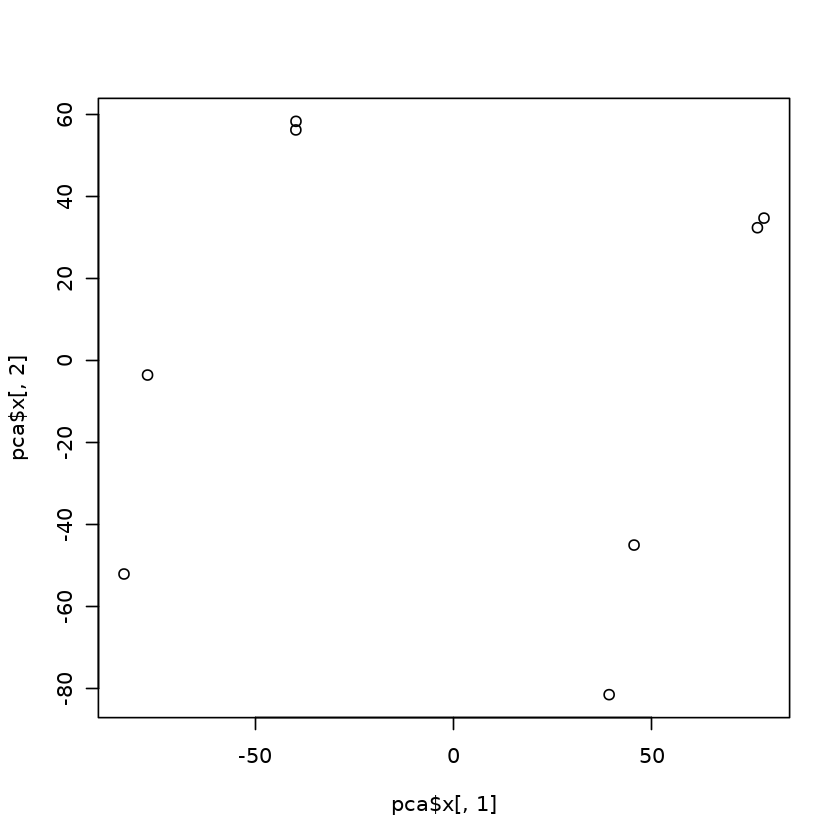

In [7]:
# Run PCA algorithm and plot
pca <- prcomp(t(log2(mat+1)))
plot(pca$x[,1], pca$x[,2])

We can make a fancier PCA plot with `ggplot`.

In [8]:
# Grab x from pca output
pca_out <- as.data.frame(pca$x)

# Get percent variance explained for x and y axes
percentage <- round(pca$sdev/sum(pca$sdev) * 100, 2)
percentage <- paste0(colnames(pca_out), " (", paste0(as.character(percentage), "%", ")"))

In [12]:
# Use column names and string manipulation to make metadata
pca_out$Sample <- colnames(mat)
pca_out$Treatment <- sapply(strsplit(colnames(mat), "_"), "[[", 1)
pca_out$Timepoint <- sapply(strsplit(colnames(mat), "_"), "[[", 4)
pca_out$Replicate <- sapply(strsplit(colnames(mat), "_"), "[[", 5)

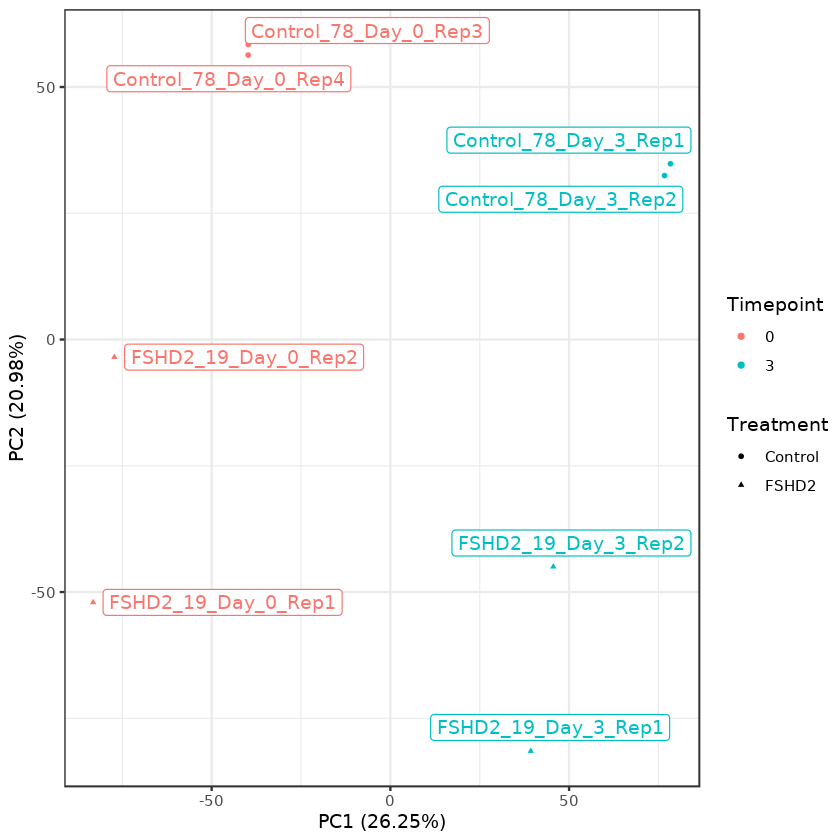

In [29]:
library(ggplot2)
library(ggrepel)

# Labels are sample, colors are timepoint
p = ggplot(pca_out,aes(x=PC1,y=PC2,color=Timepoint))+
  geom_point(aes(shape=Treatment),size=1) + 
  xlab(percentage[1]) + ylab(percentage[2]) +
  geom_label_repel(aes(label = Sample),
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50',
                   show.legend=FALSE) +
  theme_bw()
print(p)

Looks like PC1 primarily separates day 0 and day 3 samples and explains slightly more variance than PC2, which separates control and FSHD2. Let's make another PCA plot but change the [colors](https://colorbrewer2.org/) and size of the points:

In [30]:
p = ggplot(pca_out,aes(x=PC1,y=PC2,color=Timepoint))+
  geom_point(aes(shape=Treatment),size=2) + 
  xlab(percentage[1]) + ylab(percentage[2]) +
  geom_label_repel(aes(label = Sample), 
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50',
                   show.legend=FALSE) +
  theme_bw() + scale_color_manual(values=c("#1b9e77", "#d95f02"))

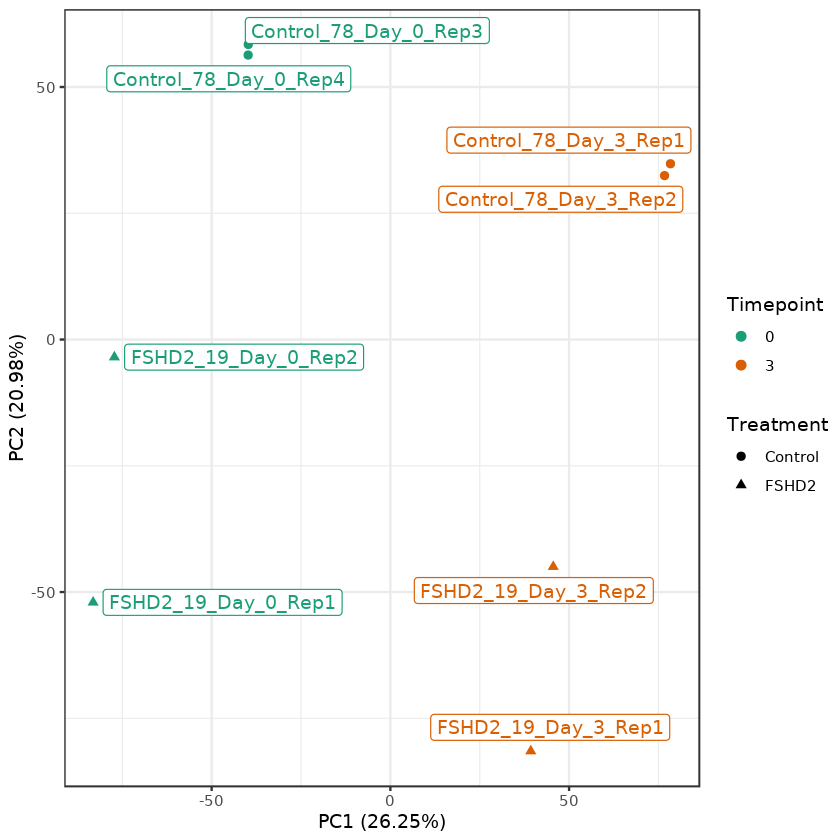

In [31]:
print(p)

Save figure to a PDF! Make a figures directory if you haven't done so:

In [23]:
system("mkdir fshd_rnaseq/figures")

In [59]:
pdf(file = "fshd_rnaseq/figures/PCA_bulkRNA_fshd.pdf",
    width = 5.5, 
    height = 5)
print(p)
dev.off()

png 
  2

### Run differential expression analysis

In [36]:
library(edgeR)

Loading required package: limma



In [32]:
# Input raw counts for edgeR
counts = as.matrix(read.csv("fshd_rnaseq/counts/fshd.counts.matrix.csv", row.names = 1))

# Remove outlier
gene_name = sapply(strsplit(rownames(counts), "[|]"), "[[", 2) # string manipulation using | as a separator
rownames(counts) = gene_name

In [33]:
# We need a metadata file -- basically already made it earlier with stringsplit operations
meta = pca_out[,c("Sample","Timepoint","Treatment","Replicate")]
head(meta)

,Sample,Timepoint,Treatment,Replicate
,<chr>,<chr>,<chr>,<chr>
Control_78_Day_0_Rep3,Control_78_Day_0_Rep3,0,Control,Rep3
Control_78_Day_0_Rep4,Control_78_Day_0_Rep4,0,Control,Rep4
Control_78_Day_3_Rep1,Control_78_Day_3_Rep1,3,Control,Rep1
Control_78_Day_3_Rep2,Control_78_Day_3_Rep2,3,Control,Rep2
FSHD2_19_Day_0_Rep1,FSHD2_19_Day_0_Rep1,0,FSHD2,Rep1
FSHD2_19_Day_0_Rep2,FSHD2_19_Day_0_Rep2,0,FSHD2,Rep2


In [34]:
meta$Treated = as.numeric(meta$Treatment == "FSHD2")
meta$Treatment = NULL
meta$Sample = NULL
head(meta)

,Timepoint,Replicate,Treated
,<chr>,<chr>,<dbl>
Control_78_Day_0_Rep3,0,Rep3,0
Control_78_Day_0_Rep4,0,Rep4,0
Control_78_Day_3_Rep1,3,Rep1,0
Control_78_Day_3_Rep2,3,Rep2,0
FSHD2_19_Day_0_Rep1,0,Rep1,1
FSHD2_19_Day_0_Rep2,0,Rep2,1


We will use [edgeR](https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf) to determine differentially expressed genes.

In [37]:
y <- DGEList(counts=counts, group=factor(meta$Timepoint))

In [277]:
# Filter lowly expressed genes
keep <- filterByExpr(y)
y <- y[keep, , keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
dim(y)

[1] 14938    34

In [38]:
# Make design matrix
design <- model.matrix(~Timepoint+Treated, data=meta)
head(design)

,(Intercept),Timepoint3,Treated
Control_78_Day_0_Rep3,1,0,0
Control_78_Day_0_Rep4,1,0,0
Control_78_Day_3_Rep1,1,1,0
Control_78_Day_3_Rep2,1,1,0
FSHD2_19_Day_0_Rep1,1,0,1
FSHD2_19_Day_0_Rep2,1,0,1


In [39]:
# Estimate dispersions
y <- estimateDisp(y,design)

In [40]:
fit <- glmQLFit(y,design)
qlf <- glmQLFTest(fit,coef=2)
topTags(qlf)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACTA1,9.240856,12.176205,1157.1333,3.893847e-253,2.314074e-248
MYLPF,9.378512,11.938113,1116.1096,2.967709e-244,8.818399e-240
MYH3,8.809951,11.511291,1097.6207,2.991852e-240,5.926760e-236
CKM,8.669372,10.013200,1000.3019,3.582329e-219,5.322356e-215
TNNC2,8.725782,9.338720,981.6075,4.019574e-215,4.777586e-211
MYL1,8.553499,9.454633,941.8768,1.631871e-206,1.616342e-202
TNNT3,8.363932,10.153991,925.2389,6.577986e-203,5.584616e-199
MYL4,8.365771,8.933300,874.7608,5.731764e-192,4.257913e-188
MYL2,8.412139,8.733814,849.9469,1.371481e-186,9.056194e-183


In [41]:
# Top 10 genes (by p value) that are differentially expressed between timepoints:
head(qlf$table[order(qlf$table$PValue),])

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ACTA1,9.240856,12.176205,1157.1333,3.893847e-253
MYLPF,9.378512,11.938113,1116.1096,2.967709e-244
MYH3,8.809951,11.511291,1097.6207,2.991852e-240
CKM,8.669372,10.013200,1000.3019,3.582329e-219
TNNC2,8.725782,9.338720,981.6075,4.019574e-215
MYL1,8.553499,9.454633,941.8768,1.631871e-206


In [42]:
qlf <- glmQLFTest(fit,coef=3)

# Top 10 genes (by p value) that are differentially expressed between FSHD and control:
head(qlf$table[order(qlf$table$PValue),])

# Upregulated in FSHD2:
fi_up = qlf$table[qlf$table$logFC > 0,]
head(fi_up[order(fi_up$PValue),])

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
AL139099.4,10.959273,12.437070,1729.8548,0.000000e+00
RN7SL2,10.119410,11.183263,1407.2250,2.983572e-307
RN7SL1,9.781920,9.533412,1159.9150,9.731635e-254
MYH7,-5.290599,9.146505,437.8079,3.817959e-97
RPS2P5,-6.321608,4.647643,382.3709,4.289743e-85
MYL1,-4.725148,9.454633,373.2462,4.135621e-83


,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
AL139099.4,10.959273,12.437070,1729.8548,0.000000e+00
RN7SL2,10.119410,11.183263,1407.2250,2.983572e-307
RN7SL1,9.781920,9.533412,1159.9150,9.731635e-254
TFPI2,4.924485,6.164193,355.2398,3.407602e-79
RN7SL3,7.497849,3.821637,353.3302,8.867327e-79
MT-RNR2,2.857097,15.721720,327.1497,4.394503e-73


We can also perform exact tests between specific samples:

In [47]:
group = substr(colnames(counts),1,nchar(colnames(counts))-5)
y <- DGEList(counts=counts, group=group)

keep <- filterByExpr(y) 
y <- y[keep, , keep.lib.sizes=FALSE]

y <- estimateDisp(y) 

Using classic mode.



In [48]:
et <- exactTest(y, pair=c("Control_78_Day_0","Control_78_Day_3"))

# order by p value
head(et$table[order(et$table$PValue),])

,logFC,logCPM,PValue
,<dbl>,<dbl>,<dbl>
MYL1,7.813415,9.457132,7.138144e-104
TNNC2,7.496845,9.341256,9.634760e-102
CKM,6.978213,10.015732,3.691412e-94
TNNT3,6.252232,10.156527,1.728648e-87
SLN,9.218732,5.805222,1.677022e-83
COX6A2,6.037747,7.553323,8.265381e-82


### Make a volcano plot


Downregulated in FSHD2        Not significant   Upregulated in FSHD2 
                   562                  57974                    893 

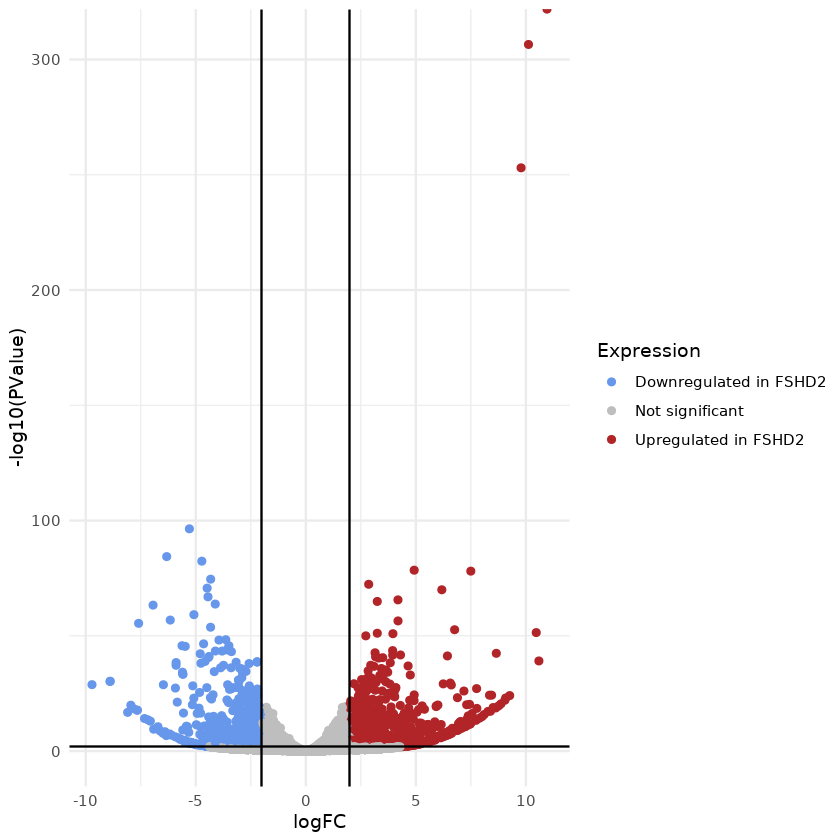

In [56]:
de_treatment= qlf$table

# add a column of NAs
de_treatment$Expression <- "Not significant"

lfc_cutoff = 2
p_cutoff = 0.01

de_treatment$Expression[de_treatment$logFC >= lfc_cutoff & de_treatment$PValue <= p_cutoff] <- "Upregulated in FSHD2"
de_treatment$Expression[de_treatment$logFC <= -lfc_cutoff & de_treatment$PValue <= p_cutoff] <- "Downregulated in FSHD2"

table(de_treatment$Expression)

ggplot(data=de_treatment, aes(x=logFC, y=-log10(PValue), col=Expression))+
  geom_point(size=1.5) + 
  theme_minimal() +
  scale_color_manual(values=c("#6697ea", "grey","#b12428")) +
  geom_vline(xintercept=c(-lfc_cutoff, lfc_cutoff), col="black") +
  geom_hline(yintercept=-log10(p_cutoff), col="black")

Warning message:
"Removed 59423 rows containing missing values (geom_text_repel)."


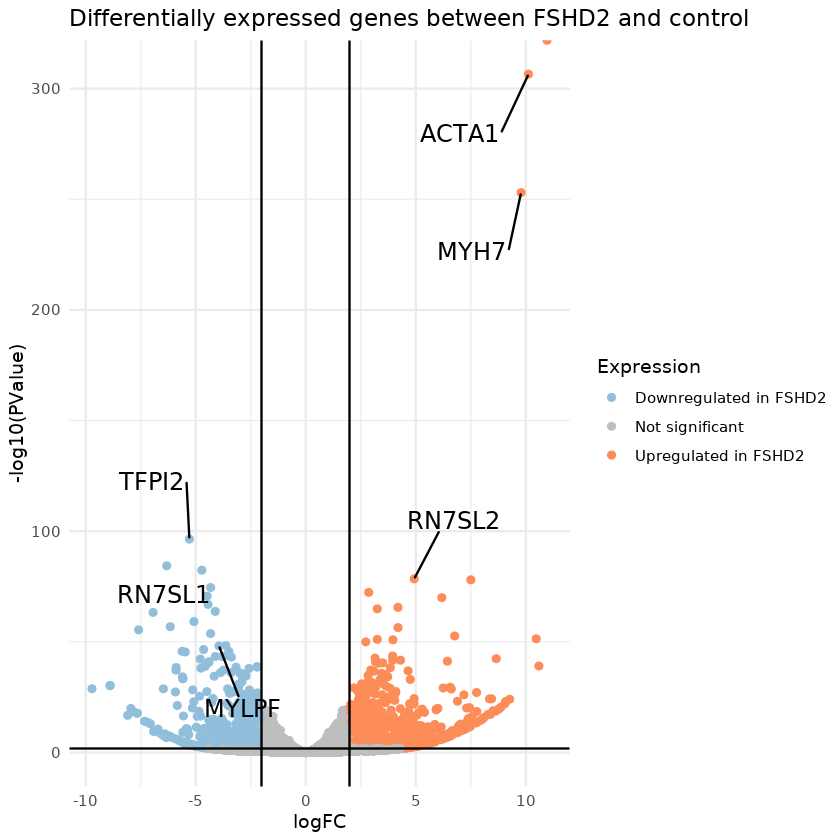

In [57]:
# Pick out some genes of interest to label, change colors, add a title
genelist = c("RN7SL1","RN7SL2","TFPI2","MYH7","ACTA1","MYLPF")
de_treatment$delabel <- NA
de_treatment$delabel[which(rownames(de_treatment) %in% genelist)] <- genelist

ggplot(data=de_treatment, aes(x=logFC, y=-log10(PValue), col=Expression, label=delabel))+
  geom_point(size=1.5) + 
  theme_minimal() +
  geom_text_repel(box.padding = 2,size = 5,color="black") +
  scale_color_manual(values=c("#91bfdb", "grey","#fc8d59")) +
  geom_vline(xintercept=c(-lfc_cutoff, lfc_cutoff), col="black") +
  geom_hline(yintercept=-log10(p_cutoff), col="black") +
  ggtitle("Differentially expressed genes between FSHD2 and control")

In [60]:
# Write the DE gene lists 
system("mkdir fshd_rnaseq/deg")

write.csv(rownames(de_treatment)[de_treatment$Expression == "Upregulated in FSHD2"], 
          file="fshd_rnaseq/deg/upreg_fshd.csv", quote=F, row.names = F)
write.csv(rownames(de_treatment)[de_treatment$Expression == "Downregulated in FSHD2"], 
          file="fshd_rnaseq/deg/downreg_fshd.csv", quote=F, row.names = F)

## Gene ontology analysis

[Metascape](http://metascape.org/gp/index.html#/main/step1) is a quick web-based method for GO analysis. Select a file or copy paste gene IDs or gene names, select the species (human), and choose Express Analysis.

# Day 2 Goals
- Run alignment job for at least 1 sample
- Load counts/TPM matrix into R and practice matrix manipulation, subsetting, etc. 
- Practice making plots with `ggplot2`
- Identify differentially expressed genes in a dataset

# Homework
- Get comfortable in Jupyter notebook hub
- Make at least one plot using ggplot in Jupyter R notebook (check tutorial links below)
- Think about some applications of differential gene expression analysis

# Useful links
- [Intro to Jupyter notebooks](https://towardsdatascience.com/a-beginners-tutorial-to-jupyter-notebooks-1b2f8705888a)
- [ggplot tutorial](http://r-statistics.co/Complete-Ggplot2-Tutorial-Part1-With-R-Code.html)  
- [Another ggplot tutorial](https://www.publichealth.columbia.edu/sites/default/files/media/fdawg_ggplot2.html)
- [edgeR tutorial](https://web.stanford.edu/class/bios221/labs/rnaseq/lab_4_rnaseq.html)